In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
#!pip install albumentations
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
# import albumentations as T
# import albumentations.augmentations.transforms as T_transforms
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For fbeta-score
from torchmetrics.functional import fbeta_score

# For nn.Sequential
from collections import OrderedDict

In [4]:
# Import tqdm for progress bar construction
import tqdm

In [5]:
# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [6]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# from google.colab import drive
# drive.mount('/content/gdrive')


# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [7]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [8]:
# Modify dataframe for K-Fold Cross Validation (ff1010)
ff1010_csv = pandas.read_csv(FF1010_Path + 'metadata.csv')
ff1010_csv.loc[ff1010_csv['hasbird'] == 0, 'filepath'] = \
    FF1010_Path + 'nocall/' + ff1010_csv.query('hasbird == 0')['filename'] + '.npy'
ff1010_csv.loc[ff1010_csv['hasbird'] == 1, 'filepath'] = \
    FF1010_Path + 'bird/' + ff1010_csv.query('hasbird == 1')['filename'] + '.npy'

ff1010_csv = ff1010_csv.dropna()
ff1010_csv = ff1010_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
ff1010_dataframe = ff1010_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(ff1010_dataframe, ff1010_dataframe['hasbird'])):
    ff1010_dataframe.loc[nth_groups, 'fold'] = int(n)

Model 1 (No-call detector)

In [9]:
# Class for ff1010 dataset
class FF1010(Dataset):
    def __init__(self, dataframe, process='train', labels='hasbird'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.JPEG),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.WEBP),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        
        # Apply transform
        if self.process == 'train':
            source = self.train_transform(Image.fromarray(source))
        elif self.process == 'valid':
            source = self.val_transform(Image.fromarray(source))
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [10]:
def evaluate_model(loader, model, beta):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)
            # In binary classification, it should be (batch size, 2) sized tensor

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.nll_loss(F.log_softmax(scores, dim=0), y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)

        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 1.

In [11]:
# Print period for accuracy.
print_period = 12

# Hyper-parameters for training 
ff1010_batch = 32
ff1010_epoch = 10

# Learning Rate.
learning_rate_1 = 0.001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 1.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 2.
# TODO: I'm curious about the output of the model: would output be the float number
#       between 0 and 1? If not, we need to add sigmoid or softmax function at the end.
model_1 = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device)),
        ("softmax", nn.Softmax(dim=-1))
]))

print(model_1)

def train_model(model, train_loader, val_loader, optimizer, beta=beta, epoch=ff1010_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    for e in range(epoch):
        print(f"Training model 1, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.nll_loss(F.log_softmax(scores), y) # Log loss for our project.
            epoch_losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # every print_period, evaluate on val_loader.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        epoch_losses = [t.double() for t in epoch_losses]
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Sequential(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [12]:
# from time import sleep

# Train loop for nocall detector
def nocall_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = FF1010(train_dataframe, process='train', labels='hasbird')
    val_data = FF1010(val_dataframe, process='valid', labels='hasbird')
    test_data = FF1010(test_dataframe, process='valid', labels='hasbird')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=ff1010_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    # Test for loaders
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate_1, weight_decay=weight_decay_1)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(val_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [13]:
# Train, Validate and Test for nocall detector
def nocall(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = nocall_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [14]:
cur_model = nn.Sequential(OrderedDict([
    ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
    ("relu", nn.ReLU().to(device)),
    ("linear", nn.Linear(1000, 2, bias=True).to(device)),
    ("softmax", nn.Softmax(dim=-1))
]))
val_losses, train_losses, log_scores, fbeta_scores, test_scores = nocall(cur_model, ff1010_dataframe, 1, 0)

for i in range(2, 5):
    cur_model = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device)),
        ("softmax", nn.Softmax(dim=-1))
    ]))
    cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, ff1010_dataframe, i, 0)
    val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
    train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
    log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
    fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
    for j in range(len(test_scores)):
        test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 1
Training model 1, epoch 1


  0%|                                                                                          | 0/144 [00:00<?, ?it/s]C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/2733252556.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = F.nll_loss(F.log_softmax(scores), y) # Log loss for our project.
  1%|█▏                                                                                | 2/144 [00:08<08:46,  3.71s/it]

Iteration 0, loss = 0.6357


 10%|███████▉                                                                         | 14/144 [00:14<00:53,  2.41it/s]

Iteration 12, loss = 0.6144


 18%|██████████████▋                                                                  | 26/144 [00:18<00:41,  2.87it/s]

Iteration 24, loss = 0.4920


 26%|█████████████████████▍                                                           | 38/144 [00:23<00:36,  2.88it/s]

Iteration 36, loss = 0.5664


 35%|████████████████████████████▏                                                    | 50/144 [00:27<00:33,  2.81it/s]

Iteration 48, loss = 0.5212


 43%|██████████████████████████████████▉                                              | 62/144 [00:32<00:28,  2.87it/s]

Iteration 60, loss = 0.6221


 51%|█████████████████████████████████████████▌                                       | 74/144 [00:37<00:27,  2.57it/s]

Iteration 72, loss = 0.6059


 60%|████████████████████████████████████████████████▍                                | 86/144 [00:41<00:19,  2.91it/s]

Iteration 84, loss = 0.4870


 68%|███████████████████████████████████████████████████████▏                         | 98/144 [00:45<00:15,  2.96it/s]

Iteration 96, loss = 0.5699


 76%|█████████████████████████████████████████████████████████████                   | 110/144 [00:50<00:11,  2.99it/s]

Iteration 108, loss = 0.4639


 85%|███████████████████████████████████████████████████████████████████▊            | 122/144 [00:54<00:07,  2.98it/s]

Iteration 120, loss = 0.5238


 93%|██████████████████████████████████████████████████████████████████████████▍     | 134/144 [00:58<00:03,  2.98it/s]

Iteration 132, loss = 0.4921


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [01:02<00:00,  2.31it/s]


Checking accuracy score on validation set.


C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/2733252556.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))



Accuracy: 1234 / 1538 correct (80.23)
Log Loss score:	3.40
Fbeta-score (beta=1): 	0.80
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:43,  3.28it/s]

Iteration 0, loss = 0.4714


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.69it/s]

Iteration 12, loss = 0.4864


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.69it/s]

Iteration 24, loss = 0.4420


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.69it/s]

Iteration 36, loss = 0.4110


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.65it/s]

Iteration 48, loss = 0.6168


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.4132


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.68it/s]

Iteration 72, loss = 0.4931


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.68it/s]

Iteration 84, loss = 0.5140


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.4973


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.67it/s]

Iteration 108, loss = 0.4281


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.4510


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.4589


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.33it/s]


Checking accuracy score on validation set.

Accuracy: 1333 / 1538 correct (86.67)
Log Loss score:	3.32
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:43,  3.28it/s]

Iteration 0, loss = 0.3927


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.5248


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.3769


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.4384


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.3551


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.68it/s]

Iteration 60, loss = 0.5068


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.68it/s]

Iteration 72, loss = 0.4951


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4596


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.66it/s]

Iteration 96, loss = 0.4470


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.67it/s]

Iteration 108, loss = 0.3974


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.4314


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.68it/s]

Iteration 132, loss = 0.3576


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.33it/s]


Checking accuracy score on validation set.

Accuracy: 1302 / 1538 correct (84.66)
Log Loss score:	3.36
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.21it/s]

Iteration 0, loss = 0.4180


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.3800


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.4350


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.4897


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.3885


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4321


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.3955


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.59it/s]

Iteration 84, loss = 0.4421


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.62it/s]

Iteration 96, loss = 0.4191


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.3751


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.3986


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.60it/s]

Iteration 132, loss = 0.4307


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1357 / 1538 correct (88.23)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.6213


  9%|███████▎                                                                         | 13/144 [00:03<00:50,  2.61it/s]

Iteration 12, loss = 0.5074


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.3731


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.3703


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.4099


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.3274


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4159


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.4409


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.64it/s]

Iteration 96, loss = 0.4320


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.4038


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.4775


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4133


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1348 / 1538 correct (87.65)
Log Loss score:	3.32
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.4294


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.66it/s]

Iteration 12, loss = 0.3988


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.4236


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.4327


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.3592


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.4026


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.3565


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.4901


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.4364


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.4060


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.4472


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4572


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1356 / 1538 correct (88.17)
Log Loss score:	3.32
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.3761


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.64it/s]

Iteration 12, loss = 0.4003


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.4370


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.4074


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.65it/s]

Iteration 48, loss = 0.4345


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.4264


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4870


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.65it/s]

Iteration 84, loss = 0.3609


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3465


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.3457


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.65it/s]

Iteration 120, loss = 0.4276


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.4119


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1354 / 1538 correct (88.04)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.19it/s]

Iteration 0, loss = 0.3763


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.4329


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.4723


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.3134


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.64it/s]

Iteration 48, loss = 0.4104


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.4752


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.3446


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.3557


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.63it/s]

Iteration 96, loss = 0.3841


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.4010


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.65it/s]

Iteration 120, loss = 0.4875


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.4026


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.28it/s]


Checking accuracy score on validation set.

Accuracy: 1372 / 1538 correct (89.21)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.22it/s]

Iteration 0, loss = 0.4167


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.64it/s]

Iteration 12, loss = 0.4434


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.63it/s]

Iteration 24, loss = 0.3834


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.3303


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.65it/s]

Iteration 48, loss = 0.3759


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:32,  2.55it/s]

Iteration 60, loss = 0.3983


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.3139


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.61it/s]

Iteration 84, loss = 0.4163


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.61it/s]

Iteration 96, loss = 0.4413


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:15,  2.28it/s]

Iteration 108, loss = 0.3461


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.60it/s]

Iteration 120, loss = 0.3804


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.64it/s]

Iteration 132, loss = 0.3897


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.20it/s]


Checking accuracy score on validation set.

Accuracy: 1369 / 1538 correct (89.01)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.21it/s]

Iteration 0, loss = 0.4239


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.64it/s]

Iteration 12, loss = 0.3476


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.3857


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.5029


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.64it/s]

Iteration 48, loss = 0.3972


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.4545


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.63it/s]

Iteration 72, loss = 0.4633


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.63it/s]

Iteration 84, loss = 0.4394


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.63it/s]

Iteration 96, loss = 0.3482


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.4047


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.3152


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.3467


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.27it/s]


Checking accuracy score on validation set.

Accuracy: 1362 / 1538 correct (88.56)
Log Loss score:	3.31
Fbeta-score (beta=1): 	0.89
Checking accuracy score on validation set.

Accuracy: 1362 / 1538 correct (88.56)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.89


Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 2
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:49,  2.89it/s]

Iteration 0, loss = 0.7766


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.65it/s]

Iteration 12, loss = 0.5709


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.5002


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.5435


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.65it/s]

Iteration 48, loss = 0.5649


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.5120


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.4651


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.65it/s]

Iteration 84, loss = 0.5345


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.6217


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.5146


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.64it/s]

Iteration 120, loss = 0.6102


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.4900


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1224 / 1538 correct (79.58)
Log Loss score:	3.40
Fbeta-score (beta=1): 	0.80
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:43,  3.27it/s]

Iteration 0, loss = 0.4674


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.4378


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.5226


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.5594


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.68it/s]

Iteration 48, loss = 0.4537


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.4367


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.5336


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4536


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.4600


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.67it/s]

Iteration 108, loss = 0.4606


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.5635


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.68it/s]

Iteration 132, loss = 0.4318


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.33it/s]


Checking accuracy score on validation set.

Accuracy: 1334 / 1538 correct (86.74)
Log Loss score:	3.32
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:43,  3.27it/s]

Iteration 0, loss = 0.3280


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.4350


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.4626


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.4427


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.4616


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.4208


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.5157


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.68it/s]

Iteration 84, loss = 0.4909


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.5103


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.67it/s]

Iteration 108, loss = 0.3528


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.5346


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.4353


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.32it/s]


Checking accuracy score on validation set.

Accuracy: 1323 / 1538 correct (86.02)
Log Loss score:	3.33
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.4806


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.4449


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.3161


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.3905


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.4247


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4645


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.4143


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4089


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.3686


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.4997


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.3817


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4203


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.31it/s]


Checking accuracy score on validation set.

Accuracy: 1329 / 1538 correct (86.41)
Log Loss score:	3.33
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.18it/s]

Iteration 0, loss = 0.4761


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.3712


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.4321


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.4709


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.4203


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4586


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.3900


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.4715


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.66it/s]

Iteration 96, loss = 0.4337


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.4857


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.3485


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4009


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.31it/s]


Checking accuracy score on validation set.

Accuracy: 1339 / 1538 correct (87.06)
Log Loss score:	3.32
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.25it/s]

Iteration 0, loss = 0.4423


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.5556


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.3967


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.4302


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.3704


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4395


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.3898


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.4372


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.66it/s]

Iteration 96, loss = 0.4366


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.4035


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.3643


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.62it/s]

Iteration 132, loss = 0.3741


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1334 / 1538 correct (86.74)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.22it/s]

Iteration 0, loss = 0.3494


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.65it/s]

Iteration 12, loss = 0.4106


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.4433


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.4883


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.4951


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4105


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.3618


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.65it/s]

Iteration 84, loss = 0.4118


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3474


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.4156


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.3769


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.3884


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1349 / 1538 correct (87.71)
Log Loss score:	3.31
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.22it/s]

Iteration 0, loss = 0.4666


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.64it/s]

Iteration 12, loss = 0.4935


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.4505


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.5521


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.4706


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.3484


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.3474


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.4100


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3472


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.4171


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.65it/s]

Iteration 120, loss = 0.4119


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.4949


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1363 / 1538 correct (88.62)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.21it/s]

Iteration 0, loss = 0.3514


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.4396


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.3782


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.4105


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.64it/s]

Iteration 48, loss = 0.3330


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.4026


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.63it/s]

Iteration 72, loss = 0.4241


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.4081


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.4690


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.5036


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.3644


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.4568


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.28it/s]


Checking accuracy score on validation set.

Accuracy: 1316 / 1538 correct (85.57)
Log Loss score:	3.31
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.21it/s]

Iteration 0, loss = 0.4944


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.64it/s]

Iteration 12, loss = 0.4574


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.3157


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.4067


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.64it/s]

Iteration 48, loss = 0.4772


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.5608


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.3820


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.4346


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.63it/s]

Iteration 96, loss = 0.4375


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.63it/s]

Iteration 108, loss = 0.3155


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.4338


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.63it/s]

Iteration 132, loss = 0.4109


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.27it/s]


Checking accuracy score on validation set.

Accuracy: 1353 / 1538 correct (87.97)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.88
Checking accuracy score on validation set.

Accuracy: 1353 / 1538 correct (87.97)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.88


C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/1290523794.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)
Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 3
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:43,  3.27it/s]

Iteration 0, loss = 0.7103


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.64it/s]

Iteration 12, loss = 0.5248


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.6991


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.6183


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.65it/s]

Iteration 48, loss = 0.5524


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.4972


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.5625


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.64it/s]

Iteration 84, loss = 0.5509


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.64it/s]

Iteration 96, loss = 0.5407


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.5197


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.5655


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.5773


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1275 / 1538 correct (82.90)
Log Loss score:	3.38
Fbeta-score (beta=1): 	0.83
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.25it/s]

Iteration 0, loss = 0.5338


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.4187


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.4983


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.4015


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.68it/s]

Iteration 48, loss = 0.5022


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.4591


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.4695


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4842


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.5011


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.68it/s]

Iteration 108, loss = 0.3807


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.4199


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.4822


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.33it/s]


Checking accuracy score on validation set.

Accuracy: 1332 / 1538 correct (86.61)
Log Loss score:	3.32
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.18it/s]

Iteration 0, loss = 0.4572


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.5094


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.4398


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.4556


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.4217


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.5135


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.4003


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4345


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.3763


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.3768


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.4519


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.5016


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.32it/s]


Checking accuracy score on validation set.

Accuracy: 1337 / 1538 correct (86.93)
Log Loss score:	3.32
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.25it/s]

Iteration 0, loss = 0.5121


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.67it/s]

Iteration 12, loss = 0.4236


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.4391


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.4998


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.5266


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4516


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.4079


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.5594


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.4603


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.3523


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.4395


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4231


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.31it/s]


Checking accuracy score on validation set.

Accuracy: 1356 / 1538 correct (88.17)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.19it/s]

Iteration 0, loss = 0.4195


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.4393


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.3815


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.4982


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.4275


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.5376


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.3749


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.4388


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.4423


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.4092


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.4418


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.3444


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1373 / 1538 correct (89.27)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.22it/s]

Iteration 0, loss = 0.4696


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.66it/s]

Iteration 12, loss = 0.4287


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.4019


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.3907


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.4087


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.3728


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.4521


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.65it/s]

Iteration 84, loss = 0.3819


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.4002


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.3474


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.4738


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.4437


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1368 / 1538 correct (88.95)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.18it/s]

Iteration 0, loss = 0.3735


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.4083


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.4859


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.3815


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.65it/s]

Iteration 48, loss = 0.4338


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.3732


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4503


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.65it/s]

Iteration 84, loss = 0.4200


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3212


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:14,  2.44it/s]

Iteration 108, loss = 0.4118


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.58it/s]

Iteration 120, loss = 0.4719


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.58it/s]

Iteration 132, loss = 0.4012


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.24it/s]


Checking accuracy score on validation set.

Accuracy: 1363 / 1538 correct (88.62)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.13it/s]

Iteration 0, loss = 0.3750


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.62it/s]

Iteration 12, loss = 0.4120


 17%|██████████████                                                                   | 25/144 [00:07<00:48,  2.47it/s]

Iteration 24, loss = 0.3910


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.4265


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.65it/s]

Iteration 48, loss = 0.4412


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.5097


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.63it/s]

Iteration 72, loss = 0.4052


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.4444


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.4624


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.3794


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.5154


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.64it/s]

Iteration 132, loss = 0.4141


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.26it/s]


Checking accuracy score on validation set.

Accuracy: 1376 / 1538 correct (89.47)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:50,  2.82it/s]

Iteration 0, loss = 0.4734


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.65it/s]

Iteration 12, loss = 0.4820


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.4104


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.4011


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.65it/s]

Iteration 48, loss = 0.5652


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.3552


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4555


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.4773


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.64it/s]

Iteration 96, loss = 0.4630


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.3422


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.4395


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.4601


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.27it/s]


Checking accuracy score on validation set.

Accuracy: 1370 / 1538 correct (89.08)
Log Loss score:	3.31
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.20it/s]

Iteration 0, loss = 0.4724


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.64it/s]

Iteration 12, loss = 0.3650


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.4423


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.3517


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.64it/s]

Iteration 48, loss = 0.4568


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.63it/s]

Iteration 60, loss = 0.3846


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.5890


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.63it/s]

Iteration 84, loss = 0.3751


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.64it/s]

Iteration 96, loss = 0.4469


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.3428


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.3596


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.4859


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.27it/s]


Checking accuracy score on validation set.

Accuracy: 1376 / 1538 correct (89.47)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.89
Checking accuracy score on validation set.

Accuracy: 1376 / 1538 correct (89.47)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.89


C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/1290523794.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/1290523794.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/1290523794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

Test set : 0, Validation set : 4
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.8797


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.6747


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.5736


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.5445


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.65it/s]

Iteration 48, loss = 0.5449


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.5098


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.5520


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.65it/s]

Iteration 84, loss = 0.5865


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.5064


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.5215


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.4398


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.3959


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1287 / 1538 correct (83.68)
Log Loss score:	3.37
Fbeta-score (beta=1): 	0.84
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.5497


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.67it/s]

Iteration 12, loss = 0.4882


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.4361


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.4248


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.5951


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.5137


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.6091


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4565


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.3709


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.68it/s]

Iteration 108, loss = 0.4628


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.3950


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.4219


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.32it/s]


Checking accuracy score on validation set.

Accuracy: 1352 / 1538 correct (87.91)
Log Loss score:	3.31
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:43,  3.26it/s]

Iteration 0, loss = 0.4457


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.4020


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.4485


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.5655


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.5588


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.3533


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.4271


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.5154


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.4030


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.3976


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.4733


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4696


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.32it/s]


Checking accuracy score on validation set.

Accuracy: 1333 / 1538 correct (86.67)
Log Loss score:	3.33
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.25it/s]

Iteration 0, loss = 0.4933


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.4208


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.5553


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.4574


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.3281


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4741


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.6054


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.3671


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.66it/s]

Iteration 96, loss = 0.4185


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.4039


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.3886


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.5300


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.31it/s]


Checking accuracy score on validation set.

Accuracy: 1353 / 1538 correct (87.97)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.3618


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.66it/s]

Iteration 12, loss = 0.4316


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.4777


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.4394


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.64it/s]

Iteration 48, loss = 0.4403


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.3790


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4954


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.3850


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.66it/s]

Iteration 96, loss = 0.4370


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.4645


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.5088


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.5103


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1360 / 1538 correct (88.43)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.21it/s]

Iteration 0, loss = 0.3440


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.3457


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.4392


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.3783


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.64it/s]

Iteration 48, loss = 0.4317


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4503


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4428


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.65it/s]

Iteration 84, loss = 0.4987


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.4201


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.3493


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.64it/s]

Iteration 120, loss = 0.3185


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.3584


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1378 / 1538 correct (89.60)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.3556


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.5125


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.4998


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.3793


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.65it/s]

Iteration 48, loss = 0.4669


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.3581


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4465


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.65it/s]

Iteration 84, loss = 0.3487


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3537


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.3777


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.65it/s]

Iteration 120, loss = 0.4086


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.3452


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1376 / 1538 correct (89.47)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.19it/s]

Iteration 0, loss = 0.3358


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.4688


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.3770


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.3943


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.65it/s]

Iteration 48, loss = 0.3794


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.4925


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.3806


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.65it/s]

Iteration 84, loss = 0.4118


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3814


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.4667


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.63it/s]

Iteration 120, loss = 0.5278


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.5399


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.28it/s]


Checking accuracy score on validation set.

Accuracy: 1358 / 1538 correct (88.30)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.20it/s]

Iteration 0, loss = 0.4404


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.3915


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.3844


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.3580


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.64it/s]

Iteration 48, loss = 0.3632


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.5566


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4039


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.4040


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.63it/s]

Iteration 96, loss = 0.3786


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.64it/s]

Iteration 108, loss = 0.3142


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.63it/s]

Iteration 120, loss = 0.4394


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.63it/s]

Iteration 132, loss = 0.3758


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.28it/s]


Checking accuracy score on validation set.

Accuracy: 1379 / 1538 correct (89.66)
Log Loss score:	3.30
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.14it/s]

Iteration 0, loss = 0.4372


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.3784


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.3760


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.4331


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.65it/s]

Iteration 48, loss = 0.3207


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.4068


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.4569


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.4669


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.64it/s]

Iteration 96, loss = 0.4362


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.63it/s]

Iteration 108, loss = 0.4144


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.3799


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.4059


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.27it/s]


Checking accuracy score on validation set.

Accuracy: 1375 / 1538 correct (89.40)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.89
Checking accuracy score on validation set.

Accuracy: 1375 / 1538 correct (89.40)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.89


C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/2589334049.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.tensor(train_losses, device = 'cpu')


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

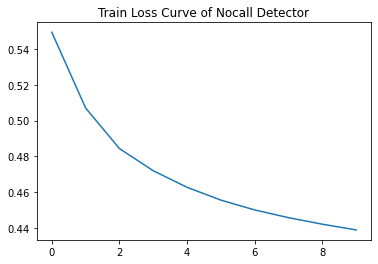

In [15]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/4126914523.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.tensor(val_losses, device = 'cpu')


Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

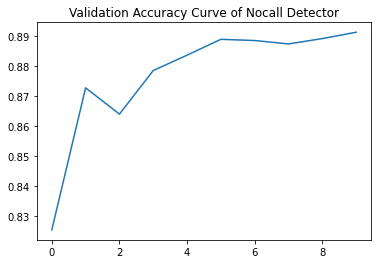

In [16]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/1290367574.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_scores = torch.tensor(log_scores, device = 'cpu')


Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

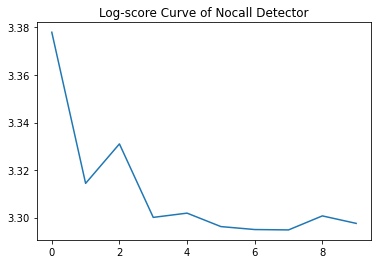

In [17]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_16996/3035292173.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')


Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

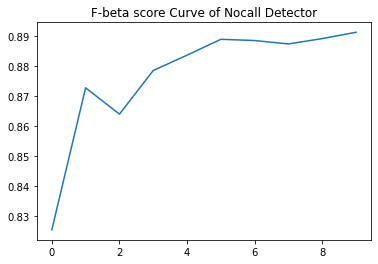

In [18]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [19]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 89.13
Log Loss score:	3.30
Fbeta-score (beta=1.0): 	0.89
